# Day 10 notebook

The objectives of this notebook are to practice

* representing characters in sequences as random variables
* computing marginal probabilities
* computing conditional probabilities
* checking for independence of random variables
* extracting features (e.g., gaps and mismatches) from an alignment
* comparing the distribution of some observations to a common distribution

## Modules used in this notebook

In [1]:
from matplotlib import pyplot as plt    # for plotting
import collections                      # for helpful functions/classes, such as Counter and defaultdict
import fasta                            # for reading sequences in FASTA format

## Python functions to consider
In this activity, you will likely find some of the functions in the [collections](https://docs.python.org/3/library/collections.html) module to be extremely helpful.  

### Counter
The [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class is very helpful for counting the number of occurrences of things.  For example,

In [2]:
print(collections.Counter("CATGATCTCATCGTACGCAACG"))
print(collections.Counter([("apple", 1), ("pear", 2), ("apple", 1), ("orange", 3)]))

Counter({'C': 7, 'A': 6, 'T': 5, 'G': 4})
Counter({('apple', 1): 2, ('pear', 2): 1, ('orange', 3): 1})


### defaultdict
The [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) class is very useful for automatically providing default values for keys in a dictionary.  For example,

In [3]:
costs = collections.defaultdict(float)
# note that no errors are raised below
# if the key is not in the dictionary, it is added with a default value of 0.0 (the result of calling float)
costs["apple"] += 1.3
costs["pear"] += 3
costs["apple"] += 0.5
print(costs)

defaultdict(<class 'float'>, {'apple': 1.8, 'pear': 3.0})


## Data sets
Here are some of the data sets we will test and/or explore with this notebook.

### Weather/Flight data set
This is the dataset provided as an example in the lecture.

We will represent a probability distribution with a dictionary for which the keys are tuples (or other "sequence"-like objects, such as strings) representing a specific configuration of random variables and the values are the floating point values corresponding to the probabilities of the configurations.  Here is the joint probability distribution for the example given in the lecture in which there are two random variables: the current weather and the arrival status of a flight.

In [4]:
weather_flight_joint_dist = {("sun",  "on-time"): 0.20,
                             ("rain", "on-time"): 0.20,
                             ("snow", "on-time"): 0.05,
                             ("sun",  "late"):    0.10,
                             ("rain", "late"):    0.30,
                             ("snow", "late"):    0.15}

We will represent a set of observations of a given system as a list of tuples (or other "sequence"-like objects, such as strings) representing a specific observation of all of the random variables in the system.  Such a set of observations can be thought of as a series of random draws from the joint probability distribution.  A set of observations for the weather/flight system is stored in the file [weather_flight_dataset.txt](weather_flight_dataset.txt), with each line corresponding to an observation.  We read this dataset from the file using the code below:

In [5]:
weather_flight_dataset = [tuple(line.split()) for line in open("weather_flight_dataset.txt")]

Here are the first 6 observations of this dataset:

In [6]:
print(*weather_flight_dataset[:6], sep="\n")

('rain', 'on-time')
('snow', 'late')
('rain', 'on-time')
('sun', 'on-time')
('sun', 'on-time')
('rain', 'late')


### Single base data set
This is a very simple dataset in which the observations are single DNA bases (sequences of length = 1).

In [7]:
single_base_joint_dist = {'A': 0.3, 'C': 0.3, 'G': 0.2, 'T': 0.2}
single_base_dataset = ['A', 'C', 'A', 'T', 'G', 'T', 'C', 'A', 'G', 'C']

## Fruit fly splice site donor sequences

One of the two main datasets you will work with in this activity is a set of sequences from the fruit fly (*Drosophila melanogaster*) genome.  These sequences are taken from intervals of the genome that are called *donor splice sites*.  Donor splice sites are signals within genes that guide the processing of RNAs transcribed from those genes.  Specifically, donor splice site signals mark the 3' boundaries of *exons*, which are the intervals of genes that are retained in mature messenger RNAs.

The set of donor sequences are found in the file [fly_donor_sequences.txt](fly_donor_sequences.txt) within this workspace.  We will first read these sequences into a list:

In [8]:
donors = [line.rstrip() for line in open("fly_donor_sequences.txt")]

Here are the first 6 donor sequences just to give you a sense of what they look like:

In [9]:
print(*donors[:6], sep="\n")

TTGGTGAGT
AAGGTATTT
TTTGTGAGT
CTGGTGAGA
CAGGTGTGC
GAGGTAAGC


## PROBLEM 1: Estimating joint distributions (1 POINT)
We will first write a function that takes a list of observations, where each observation is a sequence (e.g., a string or tuple) of random variable values and estimates a joint distribution for those random variables, by simply computing the frequency of each joint configuration of the random variables.  Consider using the [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class for this problem.

In [10]:
def estimate_joint_dist(observations):
    """Estimates the joint distribution from a list of observations.
    
    Args:
        observations: a list of observations.  Each observation should be a 
                      sequence-like object (e.g., a string or tuple), 
                      where the ith element of each sequence represents the 
                      observed value of the ith random variable.
    Returns:
        A dictionary with random variable configurations as keys and probabilities as values."""
    ###
    ### YOUR CODE HERE
    counter = collections.Counter(observations)
    return {key: count / len(observations) for key, count in counter.items()}


In [11]:
# tests for estimate_joint_dist

# Because of floating point issues, we will use the function below to 
# round probabilities such that we can check for correctness to a certain 
# number of digits.
def round_dist(dist, digits=5):
    """Returns a new distribution with probabilities rounded to the specified number of digits."""
    return {key: round(value, digits) for key, value in dist.items()}

assert round_dist(estimate_joint_dist(single_base_dataset)) == single_base_joint_dist
assert round_dist(estimate_joint_dist(weather_flight_dataset)) == weather_flight_joint_dist
assert estimate_joint_dist([("apple",)]) == {("apple",): 1.0}
assert estimate_joint_dist([(22, "apple", 3.0), (3, "banana", 1.5)]) == {(22, "apple", 3.0): 0.5,
                                                                         (3, "banana", 1.5): 0.5}
print("SUCCESS: estimate_joint_dist passed all tests!")

SUCCESS: estimate_joint_dist passed all tests!


### Examining the joint distribution of the donor sequences
Now use your function to estimate the joint distribution of the characters in the donor sequences:

In [12]:
donor_joint_dist = estimate_joint_dist(donors)

Examine this distribution.  What is the most probabable donor sequence and what is its probability?

In [14]:
###
### Your analysis here
max_prob = max(donor_joint_dist.values())
most_probable_donors = [donor for donor, prob in donor_joint_dist.items() if prob == max_prob]
print("Most probable donor sequences:", most_probable_donors, "(prob = %.3f)" % max_prob)



Most probable donor sequences: ['CAGGTGAGT'] (prob = 0.020)


## PROBLEM 2: Computing marginal distributions (1 POINT)
Now let us write a function that takes as input a joint distribution and computes the marginal distribution of one of the random variables.  Consider using the [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) class for this problem.

In [15]:
def compute_marginal_dist(joint_distribution, index):
    """Computes the marginal distribution of a single random variable given a joint distribution.
    
    Args:
        joint_distribution: A dictionary representing a joint probability distribution.  In the
                            dictionary, variable configurations are keys and probabilities are values
        index: an integer giving the index of the random variable for which the marginal 
               distribution is to be computed.  The index is with respect to the sequence objects
               that represent each variable configuration.
    Returns:
        A dictionary with the possible values of the specified random variable
        as keys and probabilities as values."""
    ###
    ### YOUR CODE HERE
    dist = collections.defaultdict(float)
    for joint_config, prob in joint_distribution.items():
        dist[joint_config[index]] += prob
    return dist
    
    


In [16]:
# tests for compute_marginal_dist
assert round_dist(compute_marginal_dist(single_base_joint_dist, 0)) == single_base_joint_dist
assert round_dist(compute_marginal_dist(weather_flight_joint_dist, 0)) == {'rain': 0.5, 'snow': 0.2, 'sun': 0.3}
assert round_dist(compute_marginal_dist(weather_flight_joint_dist, 1)) == {'late': 0.55, 'on-time': 0.45}
assert round_dist(compute_marginal_dist(donor_joint_dist, 0)) == {'A': 0.36, 'C': 0.275, 'G': 0.196, 'T': 0.169}
print("SUCCESS: compute_marginal_dist passed all tests!")

SUCCESS: compute_marginal_dist passed all tests!


### Examining the marginal distributions of the positions within donor sequences
We will now use your `compute_marginal_dist` function to compute the marginal distribution of each position within the donor sequences.

In [17]:
donor_marginal_dists = [compute_marginal_dist(donor_joint_dist, i) for i in range(len(donors[0]))]

It will be useful to plot these marginal distributions in a series of bar plots.

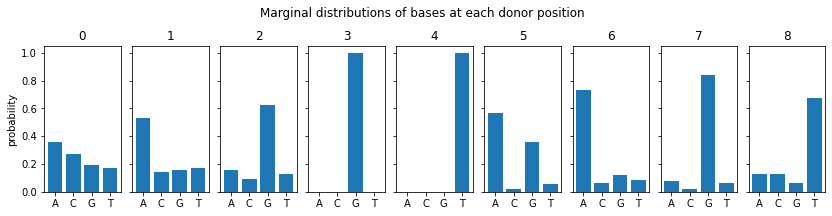

In [18]:
DNA_BASES = ("A", "C", "G", "T")

plt.figure(figsize=(14, 3))
for index, dist in enumerate(donor_marginal_dists):
    if index == 0:
        ax1 = plt.subplot(1, len(donor_marginal_dists), index + 1, title=index)
        plt.ylabel("probability")
    else:
        ax = plt.subplot(1, len(donor_marginal_dists), index + 1, sharey=ax1, title=index)
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.bar(DNA_BASES, [dist.get(base, 0) for base in DNA_BASES])
plt.suptitle('Marginal distributions of bases at each donor position')
plt.subplots_adjust(wspace=0.15, top=0.8)
plt.show()

What strikes you about these disributions?

###
### *Your observations here*
###


## PROBLEM 3: Computing conditional distributions (1 POINT)
Now let us write a function that takes as input a joint distribution and computes the conditional distribution of one of the random variables given another.  The conditional distribution should be represented as a dictionary with the keys being values of the random variable being conditioned on, and the values being distributions over the values of the other random variable.

In [19]:
def compute_conditional_dist(joint_distribution, index, condition_index):
    """Computes the conditional distribution of one random variable given another and a joint distribution.
    
    Args:
        joint_distribution: A dictionary representing a joint probability distribution.  In the
                            dictionary, variable configurations are keys and probabilities are values
        index: an integer giving the index of the target random variable for which the conditional 
               distribution is to be computed. For example, if we are computing P(X|Y), 
               this is the index of X. The index is with respect to the sequence objects
               that represent each variable configuration. 
        condition_index: an integer giving the index of the random variable on which to condition.
               For example, if we are computing P(X|Y), this is the index of Y.
    Returns:
        A dictionary with the possible values of the conditioning random variable as keys
        and distributions (represented as dictionaries) over the target variable as values."""
    ###
    ### YOUR CODE HERE
    cond_marginal = compute_marginal_dist(joint_distribution, condition_index)
    cond_dist = collections.defaultdict(lambda: collections.defaultdict(float))
    for joint_config, prob in joint_distribution.items():
        cond_dist[joint_config[condition_index]][joint_config[index]] += prob / cond_marginal[joint_config[condition_index]]
    return cond_dist
    


In [20]:
# tests for compute_conditional_dist

def round_cond_dist(cond_dist, digits=5):
    """Returns a new conditional distribution with probabilities rounded to the specified number of digits."""
    return {key: round_dist(dist, digits) for key, dist in cond_dist.items()}

assert round_cond_dist(compute_conditional_dist(weather_flight_joint_dist, 1, 0)) == \
{'rain': {'late': 0.6,     'on-time': 0.4},
 'snow': {'late': 0.75,    'on-time': 0.25},
  'sun': {'late': 0.33333, 'on-time': 0.66667}}

# Flu-symptom joint distribution from lecture
#               Variables: Flu   Fever   Vomit
flu_symptom_joint_dist = {( True,  True,  True): 0.04,
                          ( True,  True, False): 0.04,
                          ( True, False,  True): 0.01,                          
                          ( True, False, False): 0.01,                          
                          (False,  True,  True): 0.009,                          
                          (False,  True, False): 0.081,                          
                          (False, False,  True): 0.081,                          
                          (False, False, False): 0.729}
# P(Flu | Vomit)
assert round_cond_dist(compute_conditional_dist(flu_symptom_joint_dist, 0, 2)) == \
{ True: {True: 0.35714, False: 0.64286}, 
 False: {True: 0.05814, False: 0.94186}}

print("SUCCESS: compute_conditional_dist passed all tests!")

SUCCESS: compute_conditional_dist passed all tests!


### Examining conditional distributions of the positions within donor sequences
We will now use your `compute_conditional_dist` function to compute the conditional distribution of base at position 5 in the donor sequences given the base at position 7.

In [21]:
donor_5_given_7_conditional_dist = compute_conditional_dist(donor_joint_dist, 5, 7)

Here is a series of plots showing these conditional distributions.

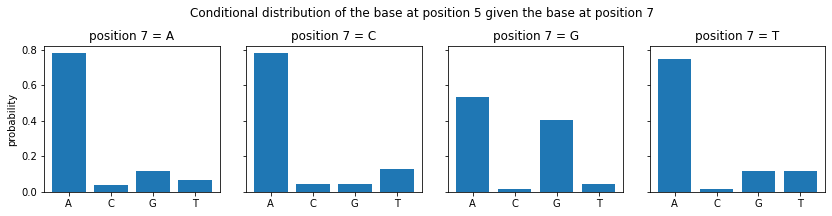

In [22]:
plt.figure(figsize=(14, 3))
for index, (base, dist) in enumerate(sorted(donor_5_given_7_conditional_dist.items())):
    if index == 0:
        ax1 = plt.subplot(1, len(donor_5_given_7_conditional_dist), index + 1, title="position 7 = " + base)
        plt.ylabel("probability")
    else:
        ax = plt.subplot(1, len(donor_5_given_7_conditional_dist), index + 1, sharey=ax1, title="position 7 = " + base)
        plt.setp(ax.get_yticklabels(), visible=False)
    plt.bar(DNA_BASES, [dist.get(base, 0) for base in DNA_BASES])
plt.suptitle('Conditional distribution of the base at position 5 given the base at position 7')
plt.subplots_adjust(wspace=0.15, top=0.8)
plt.show()

Compare the above plots to the marginal distribution of the base at position 5 in the previous section.  Does it look like the base at position 5 is *independent* of the base at position 7?

###
### *Your thoughts here*
###


## Human-Chimp genomic alignment from chromosome 21
For the remainder of this activity we will analyze the distributions of various features within a pairwise sequence alignment.  In particular, we will consider the pairwise alignment of a pair orthologous segments of the human and chimpanzee genomes.  This alignment was produced using the [MUMmer](http://mummer.sourceforge.net/) genomic alignment software.  The human segment comes from bases 26727427-26958359 of chromosome 21, and is about 231,000 bases long.  We will first read this alignment from a file [human_chimp_chr21_block.fasta](human_chimp_chr21_block.fasta), which is in FASTA format.

In [23]:
aligned_seqs = fasta.read_sequences_from_fasta_file("human_chimp_chr21_block.fasta")
human_chimp_alignment = [aligned_seq for (seq_name, aligned_seq) in aligned_seqs]

The `slice_alignment` function below will be useful for looking at pieces of this alignment, which is very long.

In [24]:
def slice_alignment(alignment, start_column, length):
    """Returns a slice of the alignment starting at start_column and with the given length."""
    return [aligned_seq[start_column: start_column + length] for aligned_seq in alignment]

And here is a view of a small 70-column slice of this alignment:

In [25]:
slice_alignment(human_chimp_alignment, 107950, 70)

['AAAGAGGAGTTCCCCTGCACAGGCTCTCTCTCTTTGCCAGCCG-CATCCACGCAAGACATGACTTGCTCC',
 'AAAGAGGAGGTCCCCTGCATAGG--CTCTCTCTTTGCCAGCCGCCATCCACGCAAGACATGACTTGCTCC']

### Gap lengths

We will first examine the gaps in this alignment, and, in particular, the lengths of the gaps.

#### PROBLEM 4: Compute gap lengths in an alignment (1 POINT)

Write a function that takes as input a *single* sequence from an alignment that potentially has gaps (consecutive runs of space (`-`) characters), and returns a list of the lengths of the gaps it contains, in left to right order.

In [31]:
def gap_lengths(s):
    """Computes a list of the lengths of the gaps in an aligned sequence
    
    Args:
        s: a string representing a single sequence from an alignment, which possibly
           contains gaps (consecutive runs of space characters, '-')
    Returns:
        A list of the lengths of the gaps in s (in left to right order)
    """
    ###
    ### YOUR CODE HERE
    lengths = []
    curr_gap_length = 0
    for c in s:
        if c == '-':
            curr_gap_length += 1
        else:
            if curr_gap_length:
                lengths.append(curr_gap_length)
                curr_gap_length = 0
    if curr_gap_length:
        lengths.append(curr_gap_length)
    return lengths




In [32]:
# tests for gap_lengths
assert gap_lengths("CTAGC---CGAT-C") == [3, 1]
assert gap_lengths("--CTAGC---CGAT-C") == [2, 3, 1]
assert gap_lengths("CTAGC---CGAT-C--") == [3, 1, 2]
assert gap_lengths("----------") == [10]
assert gap_lengths("CTAGCCGATC") == []
assert gap_lengths("") == []
print("SUCCESS: gap_lengths passed all tests!")

SUCCESS: gap_lengths passed all tests!


#### PROBLEM 5: Examination of the gap length distribution in a  human-chimp alignment (1 POINT)

We will now use your `gap_lengths` function to compile a list of all gaps from both sequences of the human-chimp alignment.

In [33]:
human_chimp_gap_lengths = gap_lengths(human_chimp_alignment[0]) + gap_lengths(human_chimp_alignment[1])
print(human_chimp_gap_lengths)

[1, 6, 2, 5, 4, 2, 3, 3, 4, 1, 4, 1, 4, 1, 1, 2, 1, 4, 2, 2, 1, 1, 2, 5, 2, 2, 2, 1, 5, 3, 3, 3, 1, 9, 1, 6, 4, 1, 1, 1, 1, 22, 1, 1, 3, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 5, 2, 1, 4, 3, 1, 2, 2, 2, 4, 2, 4, 1, 1, 3, 5, 3, 1, 1, 1, 1, 10, 1, 4, 2, 1, 1, 3, 3, 2, 2, 4, 4, 1, 3, 8, 7, 1, 3, 6, 7, 3, 7, 1, 1, 3, 1, 1, 1, 1, 1, 4, 1, 7, 7, 6, 18, 80, 1, 1, 1, 4, 1, 1, 2, 1, 34, 2, 1, 1, 1, 10, 2, 1, 1, 1, 3, 7, 1, 1, 5, 2, 2, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 6, 2, 23, 1, 2, 4, 4, 10, 9, 2, 2, 1, 2, 2, 1, 2, 1, 3, 1, 3, 1, 3, 1, 5, 9, 1, 1, 2, 1, 1, 51, 1, 1, 4, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 5, 1, 2, 2, 1, 1, 4, 4, 1, 4, 1, 8, 4, 12, 13, 3, 9, 3, 4, 1, 2, 2, 1, 14, 4, 4, 6, 1, 1, 2, 1, 5, 1, 1, 1, 1, 3, 1, 1, 1, 14, 1, 2, 4, 1, 6, 2, 2, 16, 3, 2, 3, 1, 11, 4, 4, 3, 3, 1, 1, 5, 3, 4, 1, 1, 2, 1, 1, 1, 2, 4, 15, 1, 1, 2, 1, 2, 5, 12, 72, 3, 1, 3, 2, 2, 2, 2, 1, 4, 4, 2, 4, 6, 2, 1, 6, 7, 2, 2, 1, 4, 1, 1, 7, 1, 1, 11, 1, 1, 1, 12, 4, 4, 5, 13, 2, 8, 2, 2, 1, 2, 1, 1, 1, 2, 2, 4, 1, 4, 16, 3, 1,

Use `matplotlib.pyplot` to make a plot of the distribution of the gap lengths.  I recommend using the [`pyplot.hist`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) on the list of lengths for this purpose.

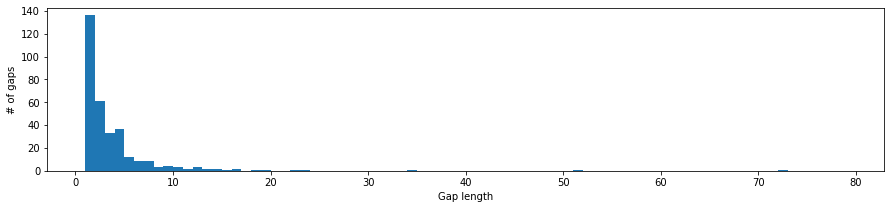

In [34]:
###
### Code for plotting a histogram of the human_chimp_gap_lengths
plt.figure(figsize=(15, 3))
plt.hist(human_chimp_gap_lengths, bins=range(min(human_chimp_gap_lengths),
                                             max(human_chimp_gap_lengths), 1))
plt.xlabel("Gap length")
plt.ylabel("# of gaps")
plt.show()


Which common distribution described in the online lecture does this gap length distribution resemble?  Record your answer by assigning one of the following strings to the `gap_length_distribution` variable.

In [39]:
common_distributions = {"geometric", "binomial", "multinomial", "gaussian", "exponential"}

In [40]:
###
gap_length_distribution = "geometric"
###


In [41]:
# tests for gap_length_count_distribution
assert gap_length_distribution in common_distributions, "The distribution must be one of the common distributions above"
###
### AUTOGRADER TEST - DO NOT REMOVE
###
print("SUCCESS: gap_length_distribution passed all visible tests!")

SUCCESS: gap_length_distribution passed all visible tests!


### Number of mismatches
Let's turn now to examining mismatches in this alignment.

#### PROBLEM 6: Compute the number of mismatches in an alignment (1 POINT)
Write a function that takes as input an alignment (represented as a list with two string elements) and returns the number of columns that have a mismatched pair of bases (ignoring gapped columns).

In [44]:
def num_mismatches(alignment):
    """Computes the number of mismatch columns (ignoring gapped columns) in alignment.
    
    Args:
        alignment: a pairwise alignment represented as a list with two string elements,
                   each string of the same length (the number of columns)
    Returns:
        The integer number of mismatch columns.
    """
    ###
    ### YOUR CODE HERE
    return sum(c1 != c2 for c1, c2 in zip(*alignment) if '-' not in (c1, c2))



In [45]:
# tests for num_mismatches
test_align1 = ["CTAGGT",
               "C-ATCT"]
assert num_mismatches(test_align1) == 2
test_align2 = ["CTAG-T",
               "C-ATCT"]
assert num_mismatches(test_align2) == 1
test_align3 = ["TTTTTT",
               "AAAAAA"]
assert num_mismatches(test_align3) == 6
test_align4 = ["",
               ""]
assert num_mismatches(test_align4) == 0
print("SUCCESS: num_mismatches passed all tests!")

SUCCESS: num_mismatches passed all tests!


#### PROBLEM 7: Examination of the distribution of the number of mismatches in slices of a human-chimp alignment (1 POINT)

Now let's use your `num_mismatches` function to count the number of mismatches in slices of the human-chimp alignment.  We will slice the alignment into disjoint slices of 1000 columns each and count the number of mismatches in each slice.

In [46]:
slice_width = 1000
mismatch_counts = [num_mismatches(slice_alignment(human_chimp_alignment, start, slice_width))
                   for start in range(0, len(human_chimp_alignment[0]), slice_width)]

Use `matplotlib.pyplot` to make a plot of the distribution of the mismatch counts.  I recommend using the [`pyplot.hist`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) for this purpose.

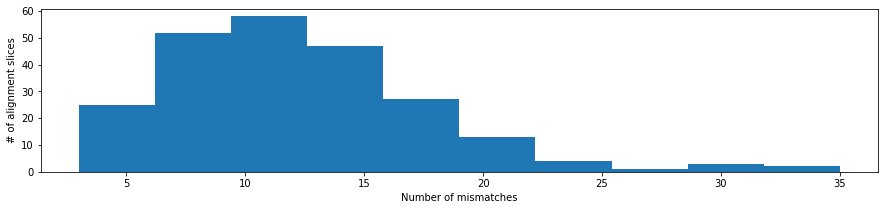

In [47]:
###
### Code for plotting a histogram of the mismatch_counts
plt.figure(figsize=(15,3))
plt.hist(mismatch_counts)
plt.xlabel("Number of mismatches")
plt.ylabel("# of alignment slices")
plt.show()


Which common distribution described in the online lecture does this mismatch count distribution resemble?  Record your answer by assigning one of the following strings to the `mismatch_count_distribution` variable.

In [49]:
###
mismatch_count_distribution = "binomial"


In [50]:
# tests for mismatch_count_distribution
assert mismatch_count_distribution in common_distributions, "The distribution must be one of the common distributions above"
###
### AUTOGRADER TEST - DO NOT REMOVE
###
print("SUCCESS: mismatch_count_distribution passed all visible tests!")

SUCCESS: mismatch_count_distribution passed all visible tests!
